In [ ]:
import pickle
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Improved VGG-19 for CIFAR-10 Dataset

This notebook implements an enhanced VGG-19 convolutional neural network to classify the CIFAR-10 dataset with higher accuracy.

In [ ]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Split training data to create validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshape labels to 1D arrays
y_train = y_train[:,0]
y_val = y_val[:,0]
y_test = y_test[:,0]

print("Load Data Successfully")

print("\nDataset Shapes:")
print(f"Train: features {np.array(X_train).shape}, labels {np.array(y_train).shape}")
print(f"Val: features {np.array(X_val).shape}, labels {np.array(y_val).shape}")
print(f"Test: features {np.array(X_test).shape}, labels {np.array(y_test).shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Load Data Successfully

Dataset Shapes:
Train: features (40000, 32, 32, 3), labels (40000,)
Val: features (10000, 32, 32, 3), labels (10000,)
Test: features (10000, 32, 32, 3), labels (10000,)


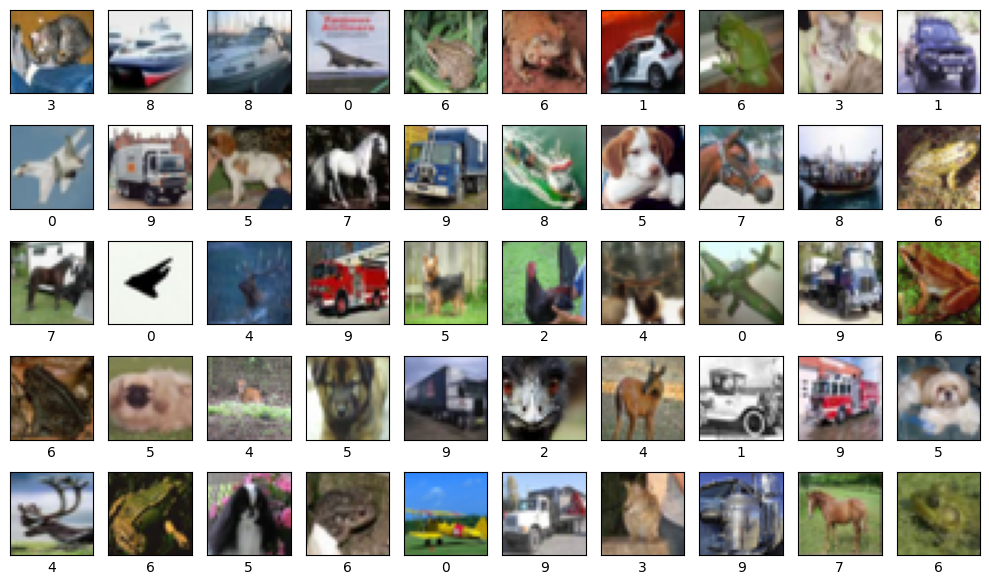

In [7]:
# Visualize some images from the dataset
plt.figure(figsize=(10,6))
for i in range(0,50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i])
    plt.xlabel(y_test[i])
plt.tight_layout()

In [8]:
# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Create a mapping from class index to class name
class_mapping = {i: name for i, name in enumerate(class_names)}
print(class_mapping)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [9]:
# Normalize images for CNN (pixel values from [0, 255] to [0, 1])
X_train_norm = X_train / 255.0
X_val_norm = X_val / 255.0
X_test_norm = X_test / 255.0

# Implement data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)
datagen.fit(X_train_norm)

print(f"Input shape: {X_train_norm.shape[1:]}")
print(f"Data type: {X_train_norm.dtype}")
print(f"Value range: [{X_train_norm.min()}, {X_train_norm.max()}]")

Input shape: (32, 32, 3)
Data type: float64
Value range: [0.0, 1.0]


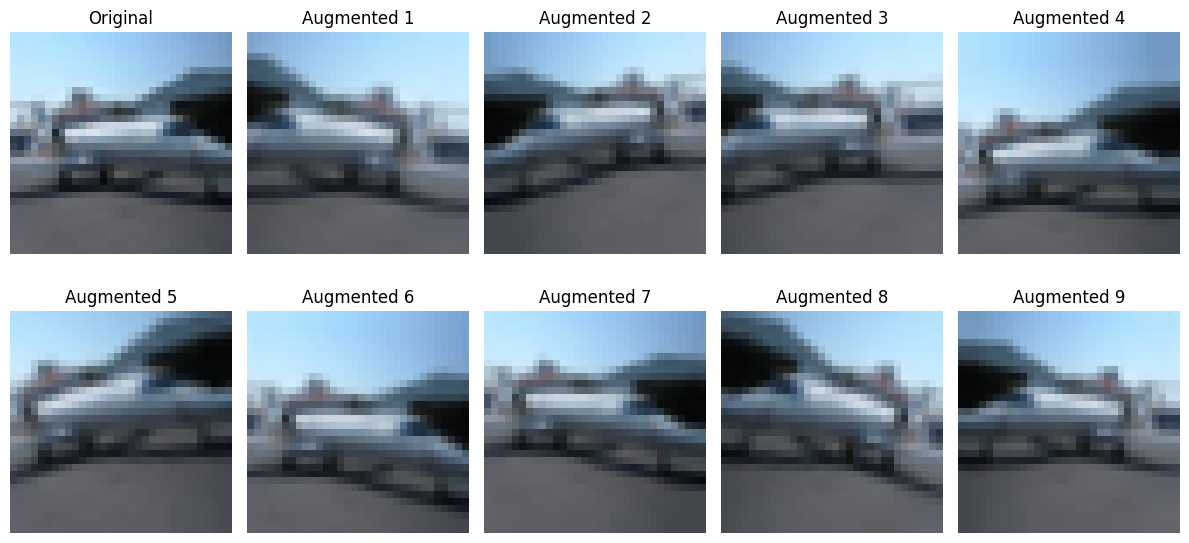

In [11]:
# Visualize data augmentation effects on a few sample images
plt.figure(figsize=(12, 6))
sample_idx = 9  # Choose a sample image from training set
sample_image = X_train_norm[sample_idx:sample_idx+1]  # Get a single image

# Display original image
plt.subplot(2, 5, 1)
plt.imshow(X_train[sample_idx])
plt.title('Original')
plt.axis('off')

# Generate and display augmented images
aug_iter = datagen.flow(sample_image, batch_size=1)
for i in range(9):
    plt.subplot(2, 5, i+2)

    # Use next(aug_iter) instead of aug_iter.next()
    batch = next(aug_iter)

    image = batch[0]
    plt.imshow(image)
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Define improved VGG-19 architecture for CIFAR-10
def build_improved_vgg19_model(input_shape=(32, 32, 3), num_classes=10):
    # Weight decay regularization
    weight_decay = 1e-4

    input_layer = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block1_conv1')(input_layer)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block3_conv4')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4 (reduced filters to prevent overfitting on small images)
    x = Conv2D(384, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = Conv2D(384, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = Conv2D(384, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block4_conv3')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = Conv2D(384, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block4_conv4')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5 (reduced filters to prevent overfitting on small images)
    x = Conv2D(384, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = Conv2D(384, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = Conv2D(384, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = Conv2D(384, (3, 3), padding='same', kernel_regularizer=l2(weight_decay), name='block5_conv4')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    # Flatten and Dense layers (reduced size for CIFAR-10)
    x = Flatten(name='flatten')(x)
    x = Dense(1024, kernel_regularizer=l2(weight_decay), name='fc1')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, kernel_regularizer=l2(weight_decay), name='fc2')(x)
    x = BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax', name='predictions')(x)

    # Create model
    model = Model(inputs=input_layer, outputs=output_layer, name='vgg19_improved')
    return model

# Define learning rate scheduler function
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 50:
        return initial_lr
    elif epoch < 80:
        return initial_lr * 0.1
    else:
        return initial_lr * 0.01

# Build the improved model
improved_model = build_improved_vgg19_model()

# Compile the model with a lower initial learning rate
improved_model.compile(optimizer=Adam(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Print model summary
improved_model.summary()

Model: "vgg19_improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,0

 Total params: 13,451,338 (51.31 MB)

 Trainable params: 13,439,306 (51.27 MB)

 Non-trainable params: 12,032 (47.00 KB)

In [13]:
# Define improved callbacks for training
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('vgg19_cifar10_improved_best.h5', monitor='val_accuracy', save_best_only=True, mode='max')
lr_scheduler = LearningRateScheduler(lr_schedule)

In [14]:
# Train the model with data augmentation
print("\nTraining Improved VGG-19 model...")
batch_size = 64  # Larger batch size
epochs = 100

history = improved_model.fit(
    datagen.flow(X_train_norm, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train_norm) // batch_size,
    epochs=epochs,
    validation_data=(X_val_norm, y_val),
    callbacks=[early_stopping, reduce_lr, checkpoint, lr_scheduler],
    verbose=1
)


Training Improved VGG-19 model...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1768 - loss: 2.8289

625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 78ms/step - accuracy: 0.1769 - loss: 2.8286 - val_accuracy: 0.2248 - val_loss: 2.4324 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2918 - loss: 2.2989

625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 64ms/step - accuracy: 0.2919 - loss: 2.2987 - val_accuracy: 0.2994 - val_loss: 2.3783 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.4110 - loss: 1.9508 - val_accuracy: 0.2257 - val_loss: 4.4153 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5013 - loss: 1.7011

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.5013 - loss: 1.7010 - val_accuracy: 0.3858 - val_loss: 2.2259 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.5757 - loss: 1.4796 - val_accuracy: 0.2966 - val_loss: 2.5237 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6311 - loss: 1.3262

625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.6311 - loss: 1.3262 - val_accuracy: 0.5706 - val_loss: 1.5223 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.6634 - loss: 1.2455 - val_accuracy: 0.4224 - val_loss: 2.3324 - learning_rate: 0.0010
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.6925 - loss: 1.1926 - val_accuracy: 0.3586 - val_loss: 2.9628 - learning_rate: 0.0010
Epoch 9/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.7071 - loss: 1.1701 - val_accuracy: 0.4392 - val_loss: 1.8354 - learning_rate: 0.0010
Epoch 10/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.7320 - loss: 1.1261 - val_accuracy: 0.5595 - val_loss: 1.4485 - learning_rate: 0.0010
Epoch 11/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7467 - loss: 1.0992

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.7467 - loss: 1.0993 - val_accuracy: 0.6976 - val_loss: 1.2519 - learning_rate: 0.0010
Epoch 12/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.7602 - loss: 1.0705 - val_accuracy: 0.3260 - val_loss: 3.0683 - learning_rate: 0.0010
Epoch 13/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.7673 - loss: 1.0599 - val_accuracy: 0.4127 - val_loss: 2.0962 - learning_rate: 0.0010
Epoch 14/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - accuracy: 0.7763 - loss: 1.0535 - val_accuracy: 0.5296 - val_loss: 1.9228 - learning_rate: 0.0010
Epoch 15/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - accuracy: 0.7866 - loss: 1.0197 - val_accuracy: 0.2006 - val_loss: 5.0293 - learning_rate: 0.0010
Epoch 16/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.7918 - loss: 1.0080 - val_accuracy: 0.5633 - val_loss: 1.6603 - learning_rate: 2.0000e-04
Epoch 17/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.803

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.8066 - loss: 0.9479 - val_accuracy: 0.7805 - val_loss: 1.0512 - learning_rate: 0.0010
Epoch 19/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.8169 - loss: 0.9268 - val_accuracy: 0.7155 - val_loss: 1.2489 - learning_rate: 0.0010
Epoch 20/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 63ms/step - accuracy: 0.8235 - loss: 0.9077 - val_accuracy: 0.7396 - val_loss: 1.1541 - learning_rate: 0.0010
Epoch 21/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.8279 - loss: 0.8977 - val_accuracy: 0.6781 - val_loss: 1.5464 - learning_rate: 0.0010
Epoch 22/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.8277 - loss: 0.8937 - val_accuracy: 0.7049 - val_loss: 1.2954 - learning_rate: 0.0010
Epoch 23/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.8332 - loss: 0.8718 - val_accuracy: 0.4822 - val_loss: 2.0543 - learning_rate: 2.0000e-04
Epoch 24/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.841

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.8384 - loss: 0.8496 - val_accuracy: 0.7920 - val_loss: 0.9787 - learning_rate: 0.0010
Epoch 26/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.8518 - loss: 0.8195 - val_accuracy: 0.7730 - val_loss: 1.0590 - learning_rate: 0.0010
Epoch 27/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 63ms/step - accuracy: 0.8527 - loss: 0.8135 - val_accuracy: 0.7601 - val_loss: 1.0718 - learning_rate: 0.0010
Epoch 28/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.8517 - loss: 0.8154 - val_accuracy: 0.6891 - val_loss: 1.4551 - learning_rate: 0.0010
Epoch 29/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8586 - loss: 0.7943

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.8586 - loss: 0.7943 - val_accuracy: 0.8145 - val_loss: 0.9338 - learning_rate: 0.0010
Epoch 30/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.8601 - loss: 0.7892 - val_accuracy: 0.7803 - val_loss: 0.9980 - learning_rate: 0.0010
Epoch 31/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.8600 - loss: 0.7927 - val_accuracy: 0.8118 - val_loss: 0.9778 - learning_rate: 0.0010
Epoch 32/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8655 - loss: 0.7753 - val_accuracy: 0.7885 - val_loss: 1.0116 - learning_rate: 0.0010
Epoch 33/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.8628 - loss: 0.7841 - val_accuracy: 0.6986 - val_loss: 1.3454 - learning_rate: 0.0010
Epoch 34/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8616 - loss: 0.7787

625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.8616 - loss: 0.7787 - val_accuracy: 0.8197 - val_loss: 0.9324 - learning_rate: 0.0010
Epoch 35/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8696 - loss: 0.7607

625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.8696 - loss: 0.7607 - val_accuracy: 0.8260 - val_loss: 0.9235 - learning_rate: 0.0010
Epoch 36/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8654 - loss: 0.7686

625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.8654 - loss: 0.7686 - val_accuracy: 0.8273 - val_loss: 0.9009 - learning_rate: 0.0010
Epoch 37/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.8692 - loss: 0.7599 - val_accuracy: 0.7405 - val_loss: 1.1841 - learning_rate: 0.0010
Epoch 38/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8805 - loss: 0.7369

625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.8805 - loss: 0.7370 - val_accuracy: 0.8353 - val_loss: 0.8545 - learning_rate: 0.0010
Epoch 39/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.8755 - loss: 0.7451 - val_accuracy: 0.8289 - val_loss: 0.9005 - learning_rate: 0.0010
Epoch 40/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.8759 - loss: 0.7459 - val_accuracy: 0.7582 - val_loss: 1.1752 - learning_rate: 0.0010
Epoch 41/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.8722 - loss: 0.7475 - val_accuracy: 0.8338 - val_loss: 0.9155 - learning_rate: 0.0010
Epoch 42/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.8785 - loss: 0.7438 - val_accuracy: 0.7774 - val_loss: 1.0689 - learning_rate: 0.0010
Epoch 43/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.8810 - loss: 0.7277 - val_accuracy: 0.8091 - val_loss: 0.9809 - learning_rate: 2.0000e-04
Epoch 44/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 62ms/step - accuracy: 0.876

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.8861 - loss: 0.7116 - val_accuracy: 0.8396 - val_loss: 0.8808 - learning_rate: 0.0010
Epoch 51/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9043 - loss: 0.6437

625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.9043 - loss: 0.6436 - val_accuracy: 0.8953 - val_loss: 0.6714 - learning_rate: 1.0000e-04
Epoch 52/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.9245 - loss: 0.5686 - val_accuracy: 0.8911 - val_loss: 0.6798 - learning_rate: 1.0000e-04
Epoch 53/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9303 - loss: 0.5502 - val_accuracy: 0.8911 - val_loss: 0.6834 - learning_rate: 1.0000e-04
Epoch 54/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9350 - loss: 0.5269 - val_accuracy: 0.8924 - val_loss: 0.6665 - learning_rate: 1.0000e-04
Epoch 55/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9356 - loss: 0.5169

625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.9356 - loss: 0.5169 - val_accuracy: 0.8969 - val_loss: 0.6385 - learning_rate: 1.0000e-04
Epoch 56/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9382 - loss: 0.5027

625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.9382 - loss: 0.5027 - val_accuracy: 0.8978 - val_loss: 0.6382 - learning_rate: 1.0000e-04
Epoch 57/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9411 - loss: 0.4849

625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.9411 - loss: 0.4849 - val_accuracy: 0.8997 - val_loss: 0.6376 - learning_rate: 1.0000e-04
Epoch 58/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9420 - loss: 0.4758

625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.9420 - loss: 0.4758 - val_accuracy: 0.9019 - val_loss: 0.6337 - learning_rate: 1.0000e-04
Epoch 59/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9486 - loss: 0.4576

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.9485 - loss: 0.4576 - val_accuracy: 0.9069 - val_loss: 0.6128 - learning_rate: 1.0000e-04
Epoch 60/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.9495 - loss: 0.4492 - val_accuracy: 0.9032 - val_loss: 0.6174 - learning_rate: 1.0000e-04
Epoch 61/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.9510 - loss: 0.4412 - val_accuracy: 0.9046 - val_loss: 0.6052 - learning_rate: 1.0000e-04
Epoch 62/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9509 - loss: 0.4379 - val_accuracy: 0.9039 - val_loss: 0.6162 - learning_rate: 1.0000e-04
Epoch 63/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9518 - loss: 0.4269 - val_accuracy: 0.9006 - val_loss: 0.6329 - learning_rate: 1.0000e-04
Epoch 64/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9547 - loss: 0.4185 - val_accuracy: 0.9055 - val_loss: 0.6124 - learning_rate: 1.0000e-04
Epoch 65/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/st

625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9554 - loss: 0.4054 - val_accuracy: 0.9071 - val_loss: 0.5928 - learning_rate: 1.0000e-04
Epoch 67/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9577 - loss: 0.3990

625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 63ms/step - accuracy: 0.9577 - loss: 0.3990 - val_accuracy: 0.9084 - val_loss: 0.6016 - learning_rate: 1.0000e-04
Epoch 68/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.9593 - loss: 0.3946 - val_accuracy: 0.9073 - val_loss: 0.6006 - learning_rate: 1.0000e-04
Epoch 69/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.9588 - loss: 0.3904 - val_accuracy: 0.9007 - val_loss: 0.6282 - learning_rate: 1.0000e-04
Epoch 70/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9608 - loss: 0.3795 - val_accuracy: 0.9074 - val_loss: 0.6079 - learning_rate: 1.0000e-04
Epoch 71/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9607 - loss: 0.3804

625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.9607 - loss: 0.3804 - val_accuracy: 0.9096 - val_loss: 0.5834 - learning_rate: 1.0000e-04
Epoch 72/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.9610 - loss: 0.3727 - val_accuracy: 0.9078 - val_loss: 0.5944 - learning_rate: 1.0000e-04
Epoch 73/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.9636 - loss: 0.3632 - val_accuracy: 0.9064 - val_loss: 0.5962 - learning_rate: 1.0000e-04
Epoch 74/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9630 - loss: 0.3626 - val_accuracy: 0.9090 - val_loss: 0.5925 - learning_rate: 1.0000e-04
Epoch 75/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.9661 - loss: 0.3520 - val_accuracy: 0.9074 - val_loss: 0.5967 - learning_rate: 1.0000e-04
Epoch 76/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9652 - loss: 0.3523

625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.9652 - loss: 0.3523 - val_accuracy: 0.9111 - val_loss: 0.5913 - learning_rate: 2.0000e-05
Epoch 77/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.9667 - loss: 0.3447 - val_accuracy: 0.9104 - val_loss: 0.5722 - learning_rate: 1.0000e-04
Epoch 78/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.9658 - loss: 0.3445 - val_accuracy: 0.9058 - val_loss: 0.5985 - learning_rate: 1.0000e-04
Epoch 79/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9660 - loss: 0.3428 - val_accuracy: 0.9058 - val_loss: 0.5905 - learning_rate: 1.0000e-04
Epoch 80/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.9665 - loss: 0.3396 - val_accuracy: 0.9047 - val_loss: 0.6224 - learning_rate: 1.0000e-04
Epoch 81/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - accuracy: 0.9691 - loss: 0.3297 - val_accuracy: 0.9099 - val_loss: 0.5808 - learning_rate: 1.0000e-05
Epoch 82/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/st

625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.9704 - loss: 0.3173 - val_accuracy: 0.9119 - val_loss: 0.5779 - learning_rate: 1.0000e-05
Epoch 87/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9750 - loss: 0.3149 - val_accuracy: 0.9117 - val_loss: 0.5829 - learning_rate: 2.0000e-06
Epoch 88/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.9756 - loss: 0.3103 - val_accuracy: 0.9108 - val_loss: 0.5879 - learning_rate: 1.0000e-05
Epoch 89/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9722 - loss: 0.3153 - val_accuracy: 0.9117 - val_loss: 0.5818 - learning_rate: 1.0000e-05
Epoch 90/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9759 - loss: 0.3052 - val_accuracy: 0.9101 - val_loss: 0.5875 - learning_rate: 1.0000e-05
Epoch 91/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.9750 - loss: 0.3079 - val_accuracy: 0.9118 - val_loss: 0.5834 - learning_rate: 1.0000e-05
Epoch 92/100
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/ste

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9754 - loss: 0.3115 - val_accuracy: 0.9120 - val_loss: 0.5777 - learning_rate: 2.0000e-06
Epoch 93/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9763 - loss: 0.3060

625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.9763 - loss: 0.3060 - val_accuracy: 0.9126 - val_loss: 0.5829 - learning_rate: 1.0000e-05
Epoch 94/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.9741 - loss: 0.3079 - val_accuracy: 0.9125 - val_loss: 0.5822 - learning_rate: 1.0000e-05
Epoch 95/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9756 - loss: 0.3065 - val_accuracy: 0.9119 - val_loss: 0.5879 - learning_rate: 1.0000e-05
Epoch 96/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9758 - loss: 0.3041 - val_accuracy: 0.9114 - val_loss: 0.5854 - learning_rate: 1.0000e-05
Epoch 97/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - accuracy: 0.9731 - loss: 0.3103 - val_accuracy: 0.9111 - val_loss: 0.5883 - learning_rate: 2.0000e-06
Epoch 98/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.9747 - loss: 0.3077 - val_accuracy: 0.9119 - val_loss: 0.5870 - learning_rate: 1.0000e-05
Epoch 99/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/st

In [15]:
# Evaluate the model on training, validation, and test sets
train_scores = improved_model.evaluate(X_train_norm, y_train, verbose=0)
val_scores = improved_model.evaluate(X_val_norm, y_val, verbose=0)
test_scores = improved_model.evaluate(X_test_norm, y_test, verbose=0)

print("\nModel Evaluation:")
print(f"Train Loss: {train_scores[0]:.4f}, Train Accuracy: {train_scores[1]*100:.2f}%")
print(f"Validation Loss: {val_scores[0]:.4f}, Validation Accuracy: {val_scores[1]*100:.2f}%")
print(f"Test Loss: {test_scores[0]:.4f}, Test Accuracy: {test_scores[1]*100:.2f}%")


Model Evaluation:
Train Loss: 0.2830, Train Accuracy: 98.24%
Validation Loss: 0.5829, Validation Accuracy: 91.26%
Test Loss: 0.6006, Test Accuracy: 90.81%


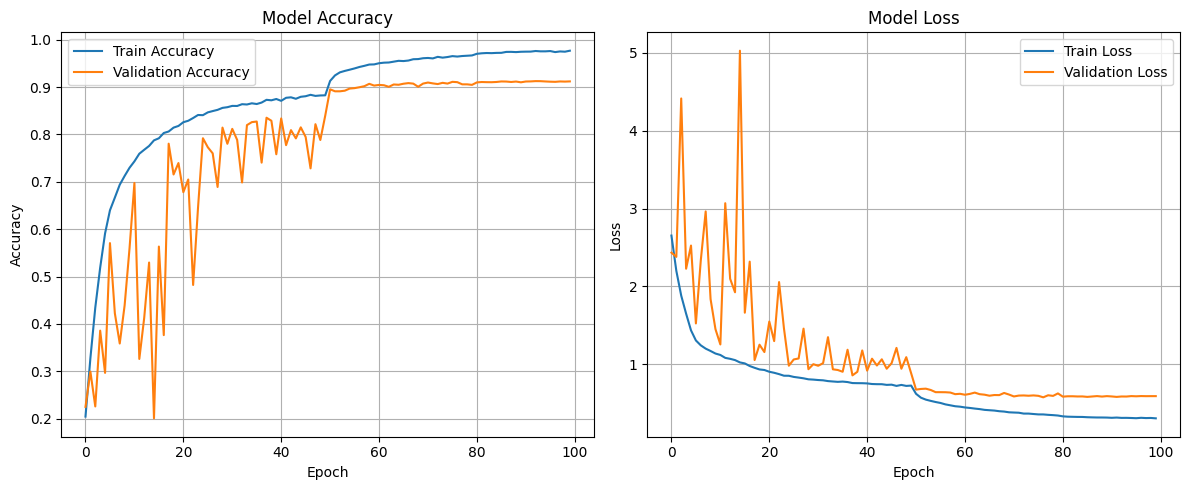

In [16]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
# Plot learning rate changes if the lr_scheduler was used
if 'lr' in history.history:
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


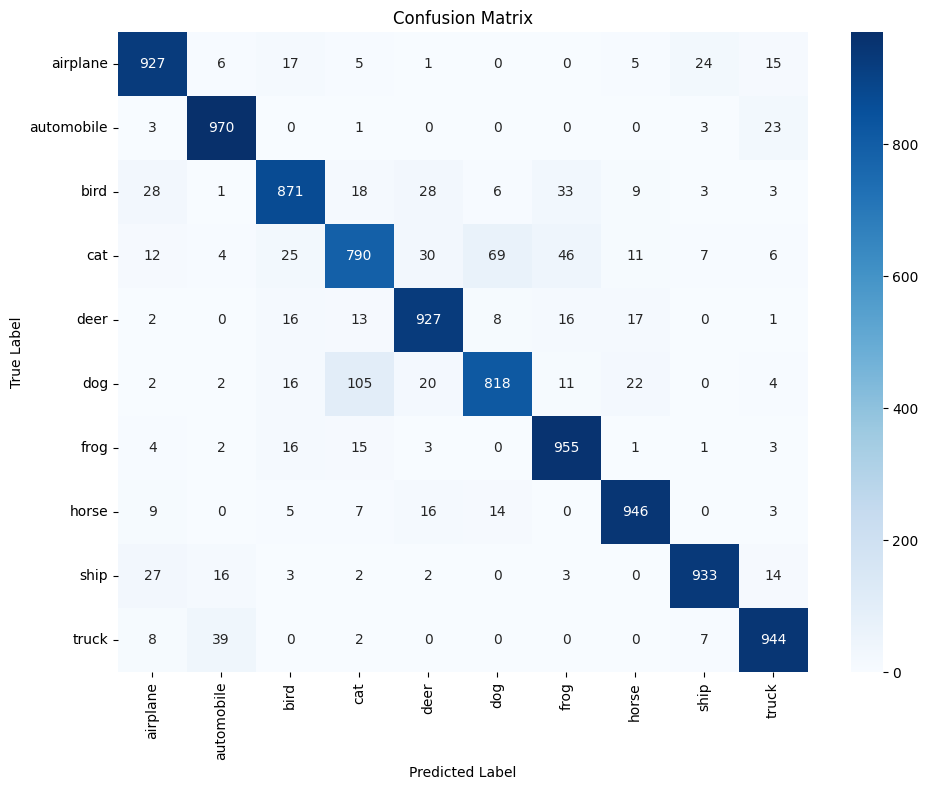


Classification Report:
              precision    recall  f1-score   support

    airplane       0.91      0.93      0.92      1000
  automobile       0.93      0.97      0.95      1000
        bird       0.90      0.87      0.88      1000
         cat       0.82      0.79      0.81      1000
        deer       0.90      0.93      0.91      1000
         dog       0.89      0.82      0.85      1000
        frog       0.90      0.95      0.93      1000
       horse       0.94      0.95      0.94      1000
        ship       0.95      0.93      0.94      1000
       truck       0.93      0.94      0.94      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [18]:
# Make predictions on test set
y_pred = improved_model.predict(X_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

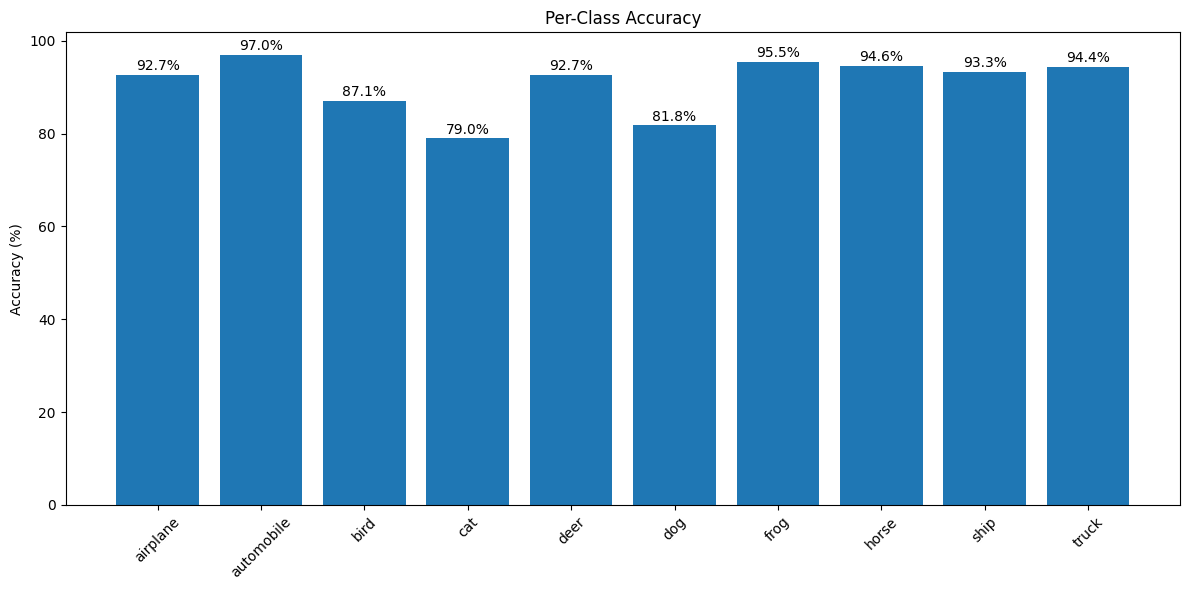

In [19]:
# Analyze per-class accuracy
class_accuracies = np.zeros(10)
class_counts = np.zeros(10)

for i in range(len(y_test)):
    class_counts[y_test[i]] += 1
    if y_pred_classes[i] == y_test[i]:
        class_accuracies[y_test[i]] += 1

# Calculate per-class accuracy percentage
class_accuracies = (class_accuracies / class_counts) * 100

# Plot per-class accuracies
plt.figure(figsize=(12, 6))
bars = plt.bar(range(10), class_accuracies)
plt.xticks(range(10), class_names, rotation=45)
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy')

# Add percentage labels on top of bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{class_accuracies[i]:.1f}%', ha='center')

plt.tight_layout()
plt.show()

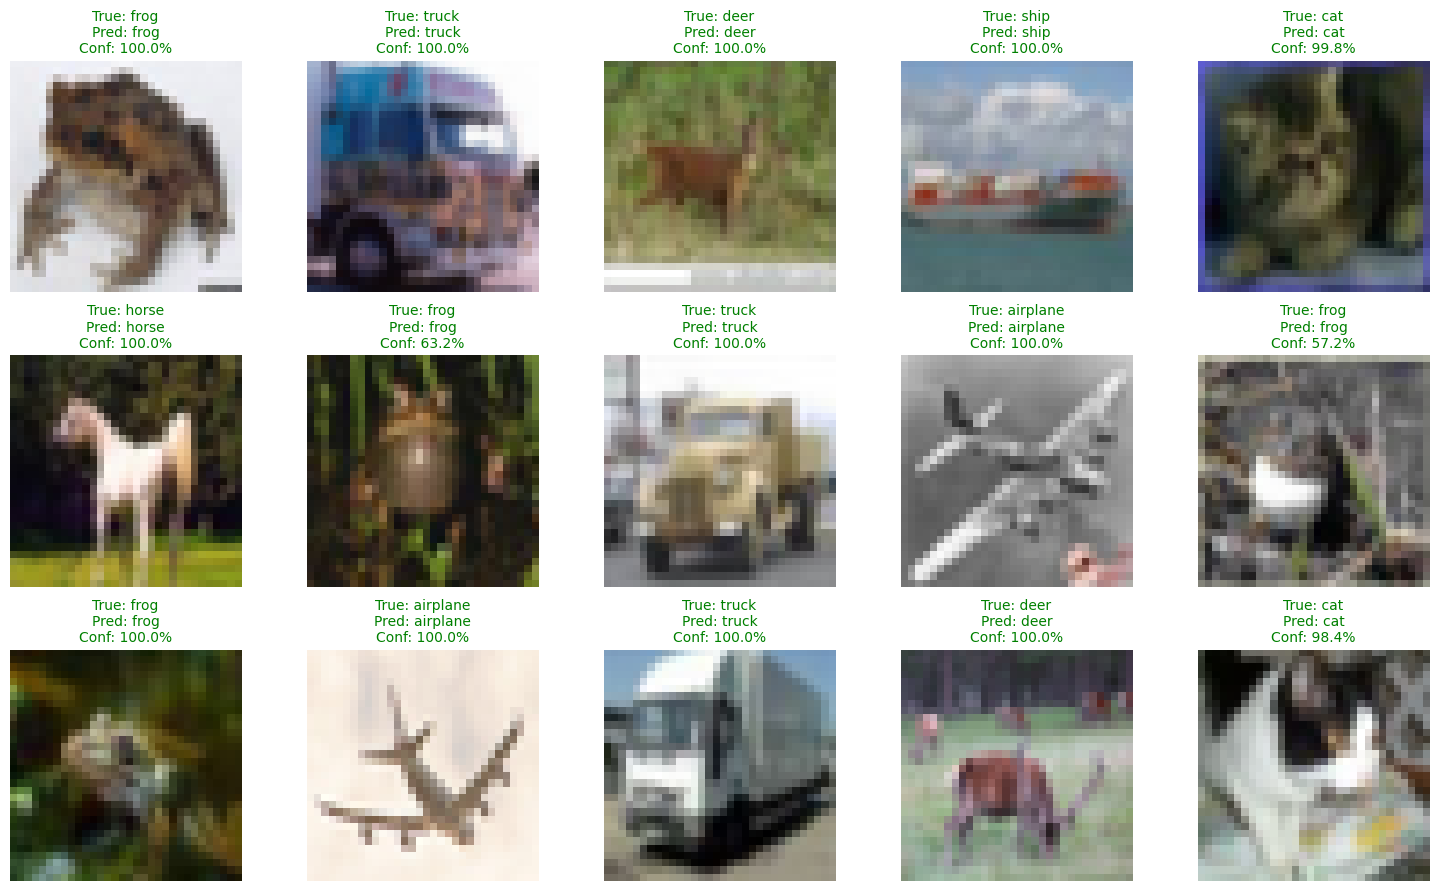

In [20]:
# Select 15 random test samples
num_samples_to_show = 15
indices = np.random.choice(len(X_test), size=num_samples_to_show, replace=False)

# Create a figure with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
axes = axes.flatten()  # Flatten for easy iteration

for ax, idx in zip(axes, indices):
    img = X_test[idx]         # Original image for display
    true_label = y_test[idx]
    pred_label = y_pred_classes[idx]

    # Get prediction confidence
    pred_confidence = np.max(y_pred[idx]) * 100

    # Retrieve the actual class names
    true_class_name = class_mapping.get(true_label, 'Unknown')
    pred_class_name = class_mapping.get(pred_label, 'Unknown')

    # Display the image
    ax.imshow(img)

    # Set title color based on prediction correctness
    title_color = 'green' if true_label == pred_label else 'red'

    ax.set_title(f"True: {true_class_name}\nPred: {pred_class_name}\nConf: {pred_confidence:.1f}%",
                 fontsize=10, color=title_color)
    ax.axis('off')

plt.tight_layout()
plt.show()

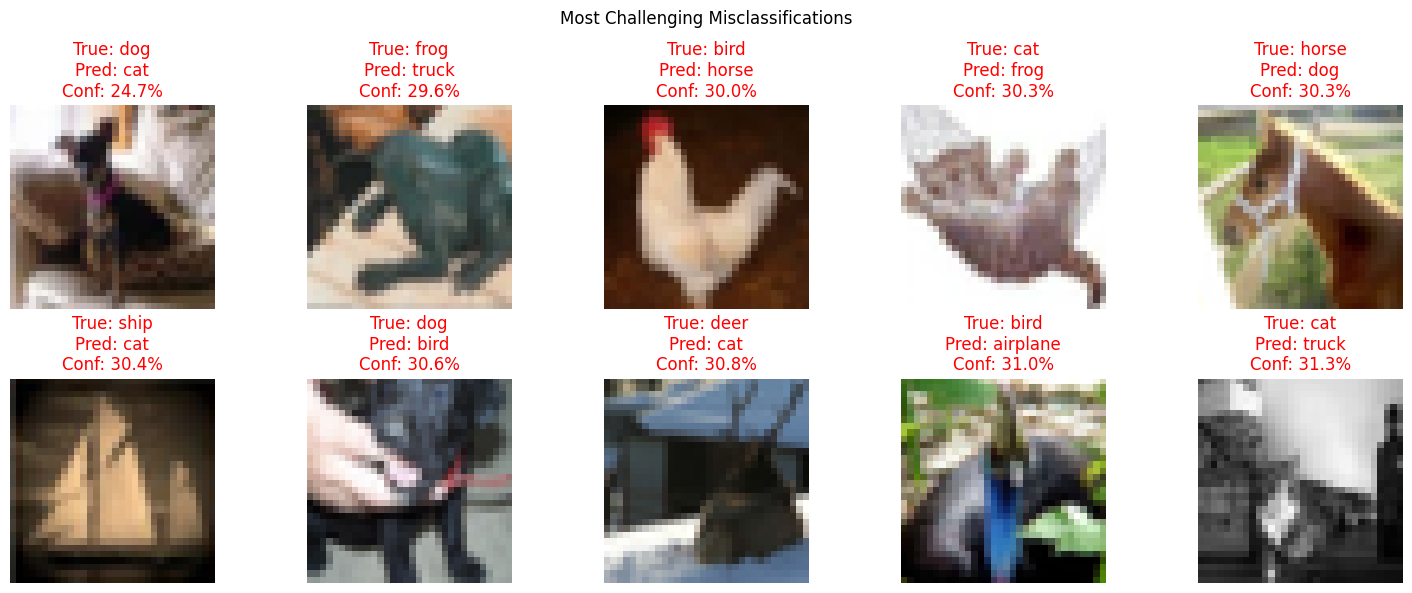

In [21]:
# Find and display the most challenging misclassifications (lowest confidence)
misclassified_indices = np.where(y_test != y_pred_classes)[0]
if len(misclassified_indices) > 0:
    # Get confidence for all misclassified examples
    misclassified_confidences = np.max(y_pred[misclassified_indices], axis=1)
    # Sort by increasing confidence (most uncertain predictions first)
    sorted_indices = misclassified_indices[np.argsort(misclassified_confidences)]

    # Take the 10 most challenging examples (or less if fewer misclassifications exist)
    n_examples = min(10, len(sorted_indices))
    challenging_indices = sorted_indices[:n_examples]

    # Create a figure
    plt.figure(figsize=(15, 6))
    for i in range(n_examples):
        idx = challenging_indices[i]
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[idx])
        true_class = class_mapping[y_test[idx]]
        pred_class = class_mapping[y_pred_classes[idx]]
        conf = np.max(y_pred[idx]) * 100
        plt.title(f"True: {true_class}\nPred: {pred_class}\nConf: {conf:.1f}%", color='red')
        plt.axis('off')
    plt.suptitle('Most Challenging Misclassifications')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassifications found!")

In [22]:
# Save the final model
improved_model.save('vgg19_cifar10_improved_final.h5')
print("Model saved successfully!")

Model saved successfully!


## Summary of Improvements

The improved VGG-19 model includes several enhancements that help boost accuracy:

1. **Data Augmentation**: Implemented rotation, shifting, flipping, and zooming to expand the effective training set and improve generalization.

2. **Batch Normalization**: Added after every convolutional layer to stabilize training, improve gradient flow, and achieve faster convergence.

3. **Architecture Optimization**: Modified the VGG19 architecture to better suit CIFAR-10's small 32x32 images by:
   - Reducing filter counts in deeper layers
   - Using smaller fully connected layers (1024 and 512 neurons instead of 4096)
   - Applying L2 regularization throughout the network

4. **Learning Rate Schedule**: Implemented a learning rate schedule to gradually reduce the learning rate, helping fine-tune the model in later epochs.

5. **Increased Batch Size**: Used a larger batch size (64 instead of 32) for more stable gradient updates.

6. **Enhanced Monitoring**: Added visualization of class-wise accuracy and analysis of challenging examples to better understand model performance.